In [23]:
#import
import pandas as pd
import numpy as np
import os
from datetime import datetime

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import warnings
import itertools

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, minmax_scale, QuantileTransformer, RobustScaler, StandardScaler

import sklearn.linear_model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

In [24]:
#define
SESSION_PATH = './sessions'
WELLNESS_PATH = './wellness'
PICKLE_PATH = './pickle/'
format = '%Y-%m-%d'

#colonne da shiftare verso l'alto

lista_colonne_workload = [
    'workload-1',
    'workload-2',
#     'workload-3',
#     'workload-4',
#     'workload-5'
                        ]
lista_colonne_rpe = [
    'rpe-1',
    'rpe-2',
#     'rpe-3',
#     'rpe-4',
#     'rpe-5'
]
lista_colonne_Go_score = [
    'Go_score-1',
    'Go_score-2',
#     'Go_score-3',
#     'Go_score-4',
#     'Go_score-5'
]

######################################
lista_category = [
    [lista_colonne_workload,'workload'],
    [lista_colonne_rpe,'rpe'],
    [lista_colonne_Go_score,'Go_score']
]
######################################
#colonne per DNN


#pesi per calcolare GO_Score

SLEEP_PAR = [0.1, 0.1, 0.5, 0.8, 1]
STRESS_PAR = [0.1, 0.1, 1, 1, 1]
FATIGUE_PAR = [0.1, 0.1, 0.5, 0.8, 1]
SORENESS_PAR = [0.1, 0.1, 0.5, 0.8, 1]
MOOD_PAR = [0.1, 0.1, 1, 1, 1]

#script per calcolare nomi colonne
nome = 'Go_score'
n = 5
lista = []
for i in range(-n,0):
    lista.append(nome+str(i))
reversed(lista)

In [25]:
def from_str_to_date(stringa):
    timestr = stringa.split(' ')[0]
    time = datetime.strptime(timestr, format)
    return time

def calcola_go(df):
    try:
        df['Go_score'] = SLEEP_PAR[int(df['wellness_sleep']) - 1] + STRESS_PAR[int(df['wellness_stress']) - 1] + FATIGUE_PAR[int(df['wellness_fatigue']) - 1] + SORENESS_PAR[int(df['wellness_soreness']) - 1] + MOOD_PAR[int(df['wellness_mood']) - 1]   
    except:
        pass
    return df

CREO UN DB CON I DATI DI TUTTI I GIOCATORI, CON COLONNE RIFERITE AI GIORNI PRECEDENTI
===========================

In [26]:
# importo csv associati a ogni player
list_files1 = os.listdir(PICKLE_PATH)
list_file = list_files1.copy()

# tolgo dalla lista dei files quelli non di player
for file in list_files1:
    if 'Player' not in file:
        list_file.remove(file)
    elif 'csv' in file:
        list_file.remove(file)

df_total = pd.DataFrame()
#per ogni file, creo e preparo il db da dare al DNN
for file in list_file:
    print(file)
    player = file.split('.')[0]
    globals()[player] = pd.read_pickle(PICKLE_PATH + file)
    
    #calcolo go score
    df_player = globals()[player].apply(calcola_go, axis=1)

    #drop delle colonne inutili
    df_player = df_player.drop(['exercises','wellness_fatigue','wellness_mood','complete',
                                'wellness_sleep','wellness_soreness','wellness_stress','Work Ratio','rpeTl','duration'], axis=1)
    
    ######################################################################################################
    #faccio le colonne shiftate
    for category in lista_category:
        i = 1
        for column in category[0]:
            df_player[column] = df_player[category[1]].shift(i)
            i += 1

    
    df_player = df_player.dropna(how='any')
    
    globals()[player] = df_player.copy()
    df_total = df_total.append(df_player, ignore_index=True)

#rinomino la colonna Player Load
df_total.rename(columns={'Player Load': 'Player_Load'}, inplace=True)

#creo la colonna previsioni
df_total['Go_score+1'] = df_total['Go_score'].shift(-1)

Player1.pickle
Player10.pickle
Player11.pickle
Player12.pickle
Player13.pickle
Player14.pickle
Player15.pickle
Player16.pickle
Player17.pickle
Player18.pickle
Player19.pickle
Player2.pickle
Player20.pickle
Player21.pickle
Player23.pickle
Player24.pickle
Player25.pickle
Player26.pickle
Player27.pickle
Player28.pickle
Player29.pickle
Player3.pickle
Player30.pickle
Player31.pickle
Player32.pickle
Player4.pickle
Player5.pickle
Player6.pickle
Player7.pickle
Player9.pickle


In [5]:
print(df_total)

      Go_score  Player_Load  cardioWorkload       date  intensity  \
0          4.4     211.0766             0.0 2017-07-13       55.9   
1          4.4       0.0000             0.0 2017-07-14        0.0   
2          3.6       0.0000             0.0 2017-07-15        0.0   
3          4.4     152.2547             0.0 2017-07-19       31.7   
4          4.4     321.7572             0.0 2017-07-20       50.8   
5          4.6     214.3411             0.0 2017-07-21       54.7   
6          4.4       0.0000             0.0 2017-07-22        0.0   
7          3.8       0.0000             0.0 2017-07-23        0.0   
8          4.4     225.7668             0.0 2017-07-24       52.1   
9          4.4     340.0522             0.0 2017-07-25       55.0   
10         4.4     265.8620             0.0 2017-07-26       56.1   
11         4.4       0.0000             0.0 2017-07-27        0.0   
12         3.5       0.0000             0.0 2017-07-28        0.0   
13         4.1     259.7995       

In [6]:
df_total.columns.values

array(['Go_score', 'Player_Load', 'cardioWorkload', 'date', 'intensity',
       'kinematicWorkload', 'mechanicalWorkload', 'metabolicWorkload',
       'perceivedWorkload', 'rpe', 'workload', 'workload-1', 'workload-2',
       'rpe-1', 'rpe-2', 'Go_score-1', 'Go_score-2', 'Go_score+1'],
      dtype=object)

In [7]:
df_total['Go_score+1'].value_counts()

5.0    765
4.8    457
4.4    369
4.6    349
4.1    122
4.3     94
4.5     71
3.8     63
3.5     47
4.0     36
3.1     23
3.6     16
3.4     14
2.7     10
3.7      9
3.9      7
3.4      5
3.0      5
3.9      4
3.2      4
0.5      3
2.1      2
1.8      2
2.6      1
1.8      1
2.3      1
3.7      1
1.4      1
0.9      1
Name: Go_score+1, dtype: int64

RETE NEURALE 
============================

In [8]:
#define
OUTPUT = 'Go_score+1'
EPOCHS = 1000
HIDDEN_UNITS = [1000]

In [9]:
#drop colonne inutili
train = df_total.drop(['date','playerName','cardioWorkload','intensity','Player_Load','rpe'],axis = 1)

#drop dati a 0
train = train[train['workload']!=0]

#droppo colonne con parametri go troppo bassi
colonne_go = ['Go_score']+lista_colonne_Go_score+[OUTPUT]
        
for colonna in colonne_go:
    train = train[train[colonna]>= 2]

# #muovo go_score+1 in fondo
# serie = train[OUTPUT]
# train = train.drop([OUTPUT],axis=1)
# train[OUTPUT] = serie

input_dataset = train.copy()
train

,Go_score,kinematicWorkload,mechanicalWorkload,metabolicWorkload,perceivedWorkload,workload,workload-1,workload-2,rpe-1,rpe-2,Go_score-1,Go_score-2,Go_score+1
0,4.4,23.6,44.6,30.7,20.8,1.6,1.4,2.2,3.0,5.0,4.4,4.4,4.4
3,4.4,11.3,15.6,2.9,20.6,0.7,1.5,1.9,4.0,4.0,4.4,4.4,4.4
4,4.4,41.8,49.1,35.4,51.3,2.2,0.7,1.5,2.0,4.0,4.4,4.4,4.6
5,4.6,21.2,39.2,19.6,20.7,1.3,2.2,0.7,4.0,2.0,4.4,4.4,4.4
8,4.4,28.0,44.7,30.5,32.3,1.7,0.0,0.0,0.0,0.0,3.8,4.4,4.4
9,4.4,30.6,39.5,32.6,47.3,1.9,1.7,0.0,3.0,0.0,4.4,3.8,4.4
10,4.4,27.3,36.8,28.3,31.3,1.6,1.9,1.7,4.0,3.0,4.4,4.4,4.4
13,4.1,29.0,43.1,32.7,40.6,1.8,0.0,0.0,0.0,0.0,3.5,4.4,4.1
16,4.1,25.2,39.9,32.2,30.6,1.6,0.0,0.0,0.0,0.0,3.0,4.1,4.4
17,4.4,20.3,30.9,19.0,30.5,1.3,1.6,0.0,3.0,0.0,4.1,3.0,4.4


Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\LucaC\\AppData\\Local\\Temp\\tmp47t6hb6a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015902576F98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\LucaC\\AppData\\Local\\Temp\\tmpjsveoeex', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, 

c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


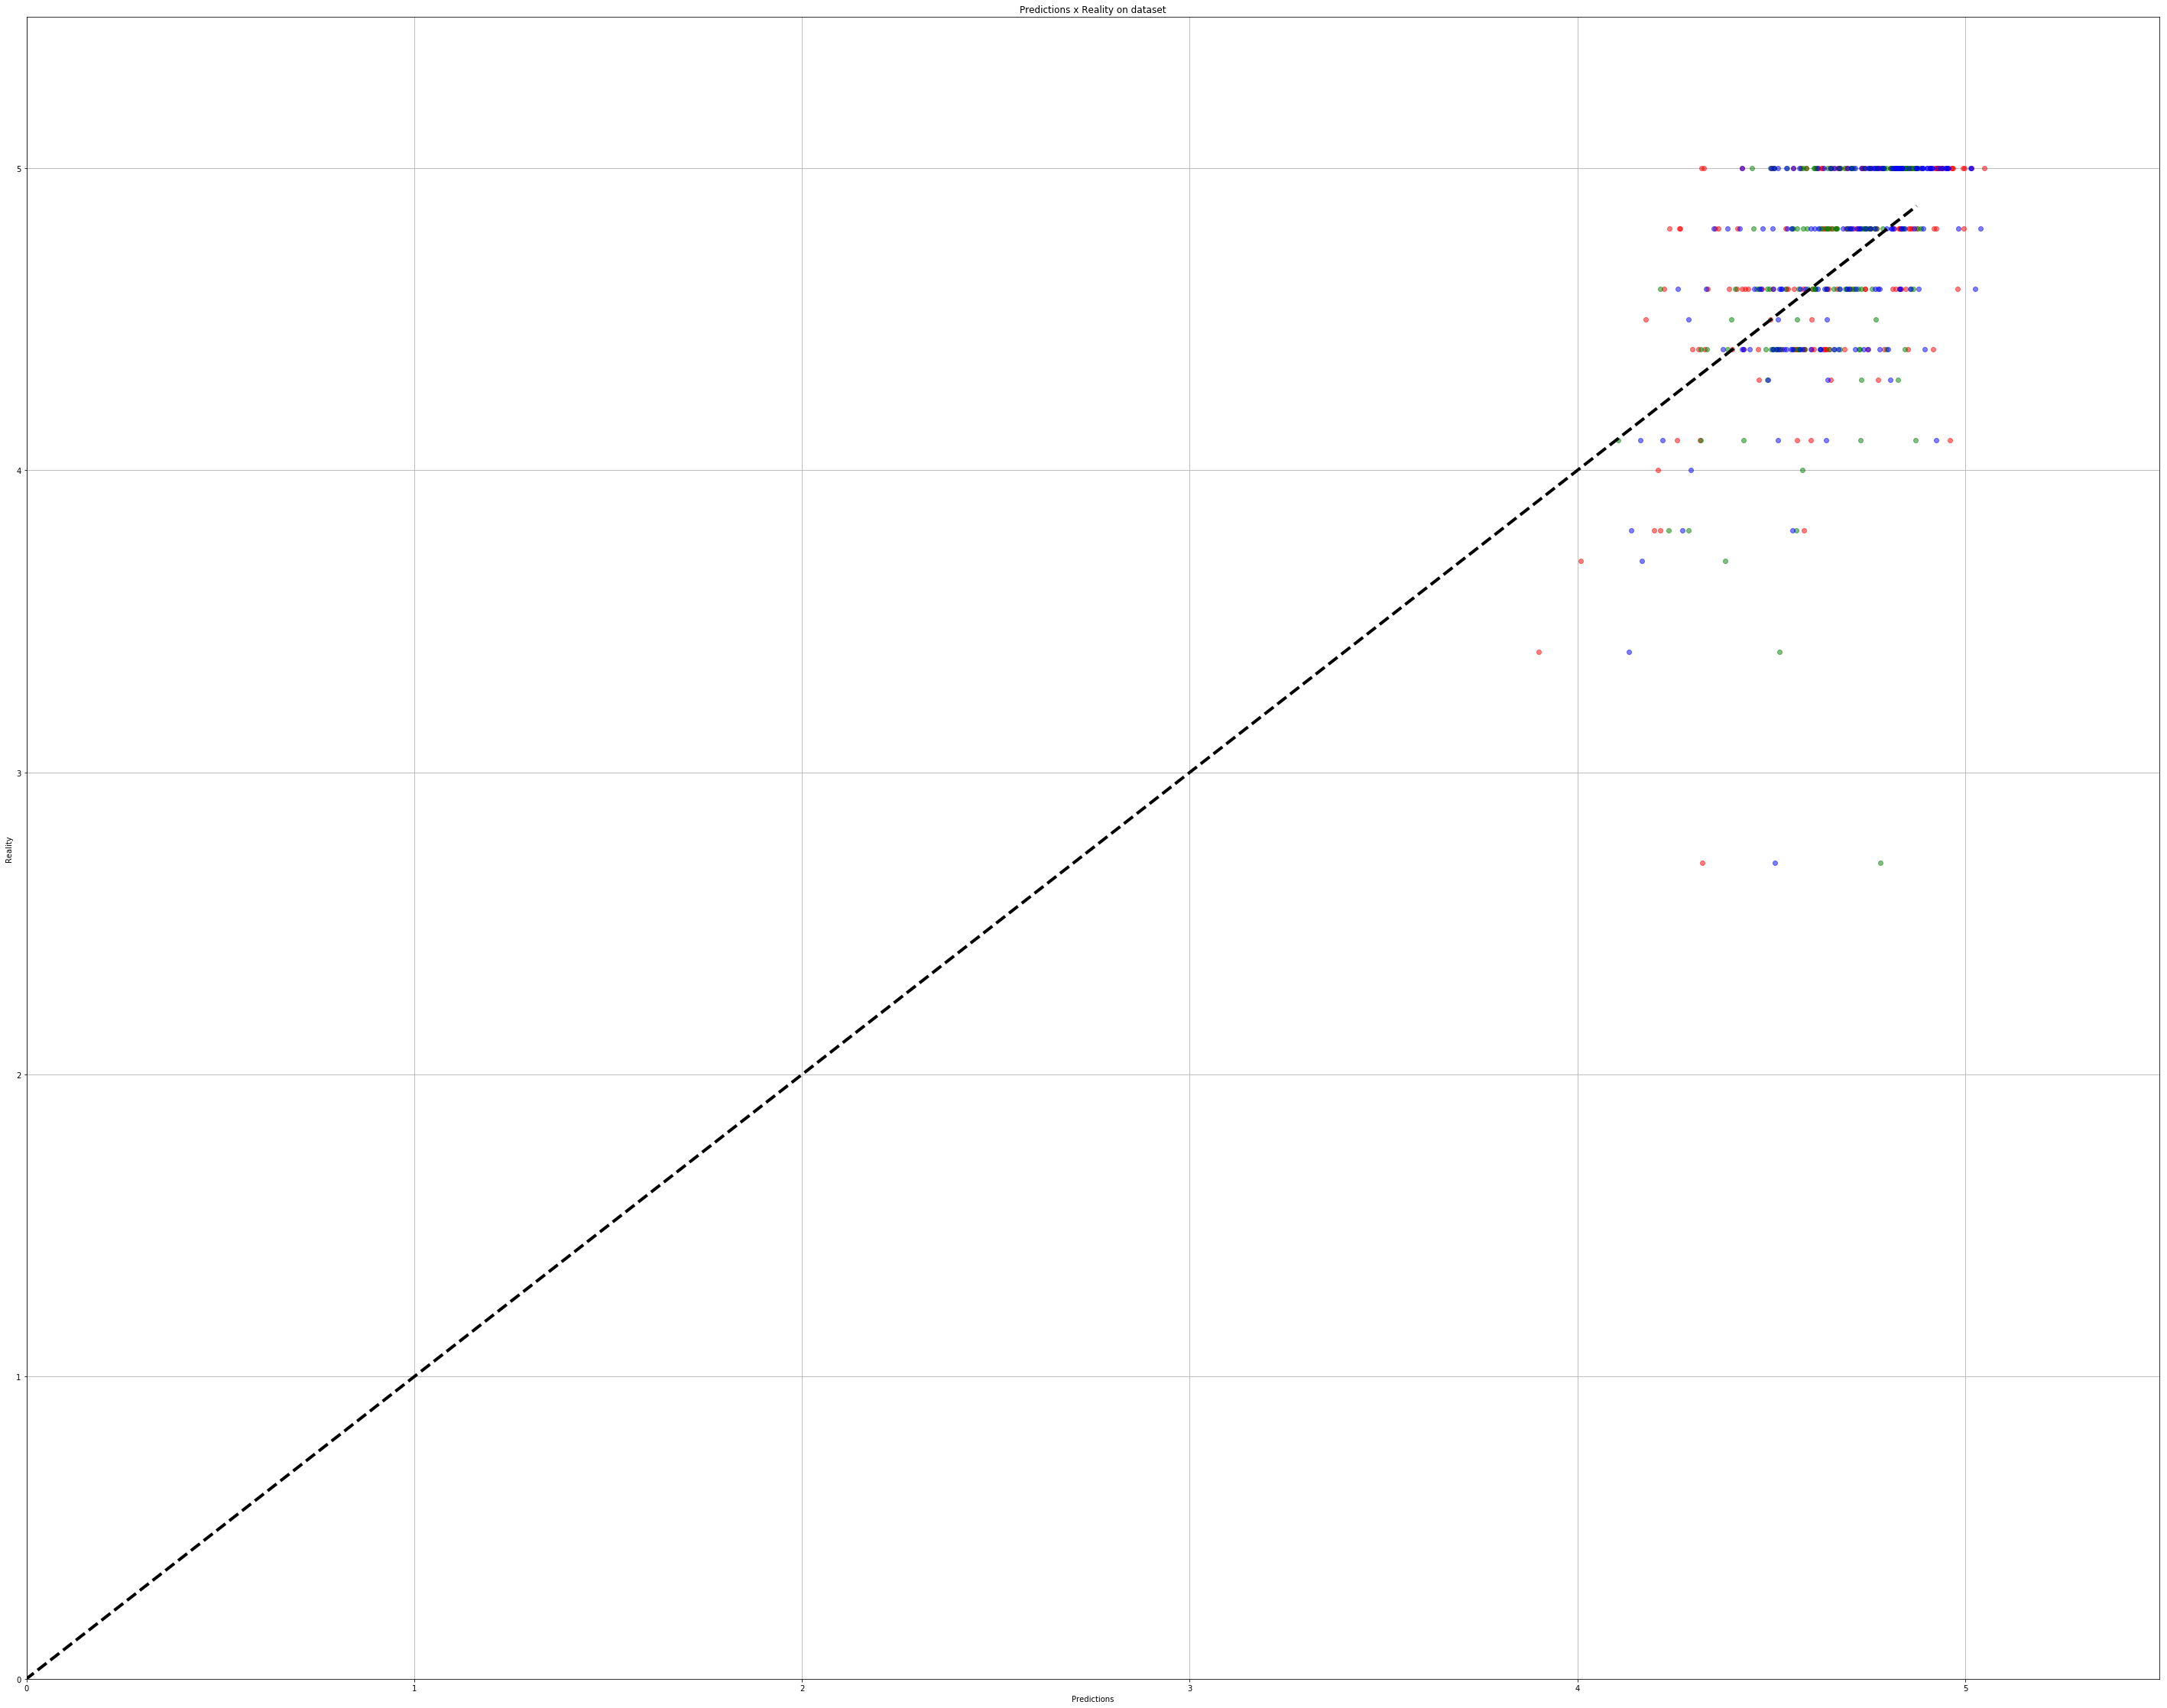

In [10]:
# Isolate outliers with an IsolationForest algorithm


'''clf = IsolationForest(max_samples=1000, random_state=42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns=['Top'])
y_noano[y_noano['Top'] == 1].index.values
train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop=True, inplace=True)
print('')
print('Number of Outliers:', y_noano[y_noano['Top'] == -1].shape[0])
print('Number of rows without outliers:', train.shape[0])'''


# Preprocessing dataset with MinMaxScale function

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove(OUTPUT)

# mat_train = np.matrix(train)
# #mat_input = np.matrix(input_dataset)
# mat_new = np.matrix(train.drop(OUTPUT, axis=1))
# mat_y = np.array(train[OUTPUT].reshape((train.shape[0], 1)))

# prepro_y = MinMaxScaler()
# prepro_y.fit(mat_y)

# prepro = MinMaxScaler()
# prepro.fit(mat_train)

# prepro_input = MinMaxScaler()
# prepro_input.fit(mat_new)

mat_train = train.copy()
# prepro = MinMaxScaler(copy=True, feature_range=(0, 1))
# prepro = QuantileTransformer(ignore_implicit_zeros=True)
# prepro = RobustScaler()
prepro = StandardScaler(copy=True, with_mean=True, with_std=True)

# prepro_y = MinMaxScaler(copy=True, feature_range=(0, 1))
# prepro_y = QuantileTransformer(ignore_implicit_zeros=True)
# prepro_y = RobustScaler()
prepro_y = StandardScaler(copy=True, with_mean=True, with_std=True)

mat_y = prepro_y.fit_transform(train[OUTPUT].values.reshape(-1,1))

train = pd.DataFrame(prepro.fit_transform(mat_train), columns=col_train)

#input_dataset = pd.DataFrame(prepro_input.transform(mat_input), columns=col_train_bis)

# TensorFlow deep neural network

# List of features

COLUMNS = col_train
FEATURES = col_train_bis

# Columns for tensorflow

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict

training_set = train[COLUMNS]
prediction_set = train[OUTPUT]

# Train and Test split


x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES], prediction_set, test_size=0.1, random_state=42)
y_train = pd.DataFrame(y_train, columns=[OUTPUT])
training_set = pd.DataFrame(x_train, columns=FEATURES).merge(y_train, left_index=True, right_index=True)


# Training for submission


training_sub = training_set[col_train]
y_test = pd.DataFrame(y_test, columns=[OUTPUT])
testing_set = pd.DataFrame(x_test, columns=FEATURES).merge(y_test, left_index=True, right_index=True)


# Model

tf.logging.set_verbosity(tf.logging.INFO)
regressor = tf.estimator.DNNRegressor(hidden_units= HIDDEN_UNITS, 
                                      feature_columns=feature_cols, 
                                      model_dir=None,
                                      label_dimension=1,
                                      weight_column=None,
                                      optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
#                                       optimizer=tf.train.ProximalAdagradOptimizer(
#                                                                                   learning_rate=0.001,
#                                                                                   l1_regularization_strength=0.001
#                                                                                   ),
                                      activation_fn=tf.nn.relu,
                                      dropout=0.3,
                                      input_layer_partitioner=None,
                                      config=None,
                                      warm_start_from=None,
                                      loss_reduction= tf.losses.Reduction.SUM
                                     )

linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_cols)

lr_sklearn = sklearn.linear_model.LinearRegression(fit_intercept=False, copy_X=True, n_jobs=-1)

# Reset the index of training

training_set.reset_index(drop=True, inplace=True)

# Deep Neural Network Regressor with the training set which contain the data split by train test split

regressor.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = training_set, y = training_set[OUTPUT], 
                                                             shuffle=False), steps=EPOCHS)

linear_regressor.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = training_set, y = training_set[OUTPUT], 
                                                             shuffle=False))

lr_sklearn.fit(np.matrix(training_set.drop([OUTPUT], axis=1)),np.array(training_set[OUTPUT].values.reshape((training_set.shape[0], 1))))

# # Evaluation on the test set created by train_test_split


# ev = regressor.evaluate(input_fn=tf.estimator.inputs.pandas_input_fn(x = testing_set,y = testing_set[OUTPUT],
#                                                                          shuffle=False), steps=1)


# # Display the score on the testing set


# loss_score1 = ev['loss']
# print('')
# print('Final Loss on the testing set: {0:f}'.format(loss_score1))
# print('')

# Predictions on testing set


y = regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(testing_set, shuffle=False))
predictions1 = list(itertools.islice(y, testing_set.shape[0]))

linear_y = linear_regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(testing_set, shuffle=False))
linear_predictions1 = list(itertools.islice(linear_y, testing_set.shape[0]))

lr_sklearn_y = lr_sklearn.predict(np.matrix(testing_set.drop([OUTPUT], axis=1)))

#inverse transformation of data

try:
    predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in predictions1]).reshape(len(x_test), 1))
    reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values
except:
    predictions = (np.array([x['predictions'] for x in predictions1]).reshape(len(x_test), 1))
    reality = np.array((testing_set)[OUTPUT].values).reshape(len(x_test), 1)

try:
    linear_predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in linear_predictions1]).reshape(len(x_test), 1))
    linear_reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values
except:
    linear_predictions = (np.array([x['predictions'] for x in linear_predictions1]).reshape(len(x_test), 1))
    linear_reality = np.array((testing_set)[OUTPUT].values).reshape(len(x_test), 1)

lr_sklearn_predictions = prepro_y.inverse_transform(lr_sklearn_y)
lr_sklearn_reality = linear_reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values

# Plot predictions x reality on dataset graph
    
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([0, 5.5])
axes.set_ylim([0, 5.5])
plt.style.use('default')
plt.plot(predictions, reality, 'ro', color='red',alpha = 0.5)
plt.plot(linear_predictions, linear_reality, 'ro', color='green',alpha = 0.5)
plt.plot(lr_sklearn_predictions, lr_sklearn_reality, 'ro', color='blue',alpha = 0.5)
plt.xlabel('Predictions')
plt.ylabel('Reality')
plt.title('Predictions x Reality on dataset')
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

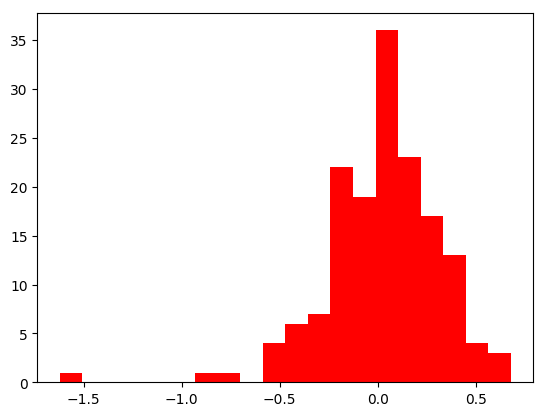

In [11]:
error = []
for x in (reality) - predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20,color='red') # plotting by columns
plt.show()

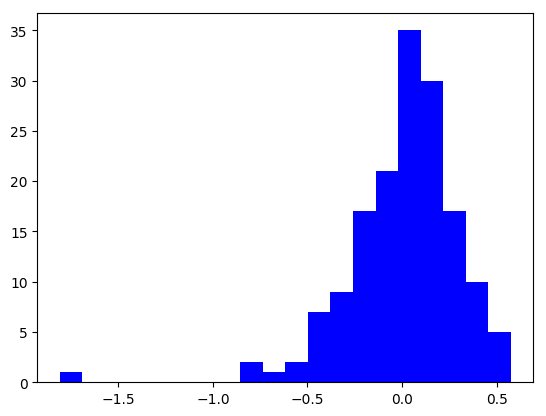

0.31896016760545265


In [12]:
error = []
for x in (lr_sklearn_reality) - lr_sklearn_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20, color='blue') # plotting by columns
plt.show()

print(lr_sklearn.score(np.matrix(testing_set.drop([OUTPUT], axis=1)),
                       np.array(testing_set[OUTPUT].values.reshape((testing_set.shape[0], 1)))))

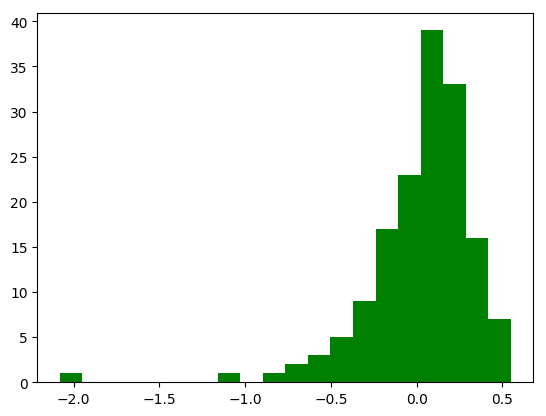

In [13]:
error = []
for x in (linear_reality) - linear_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20, color='green') # plotting by columns
plt.show()

INFO:tensorflow:Calling model_fn.


Exception ignored in: <generator object Estimator.predict at 0x0000015903B9A8E0>
Traceback (most recent call last):
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 5086, in get_controller
    yield g
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LucaC\AppData\Local\Temp\tmp47t6hb6a\model.ckpt-11
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


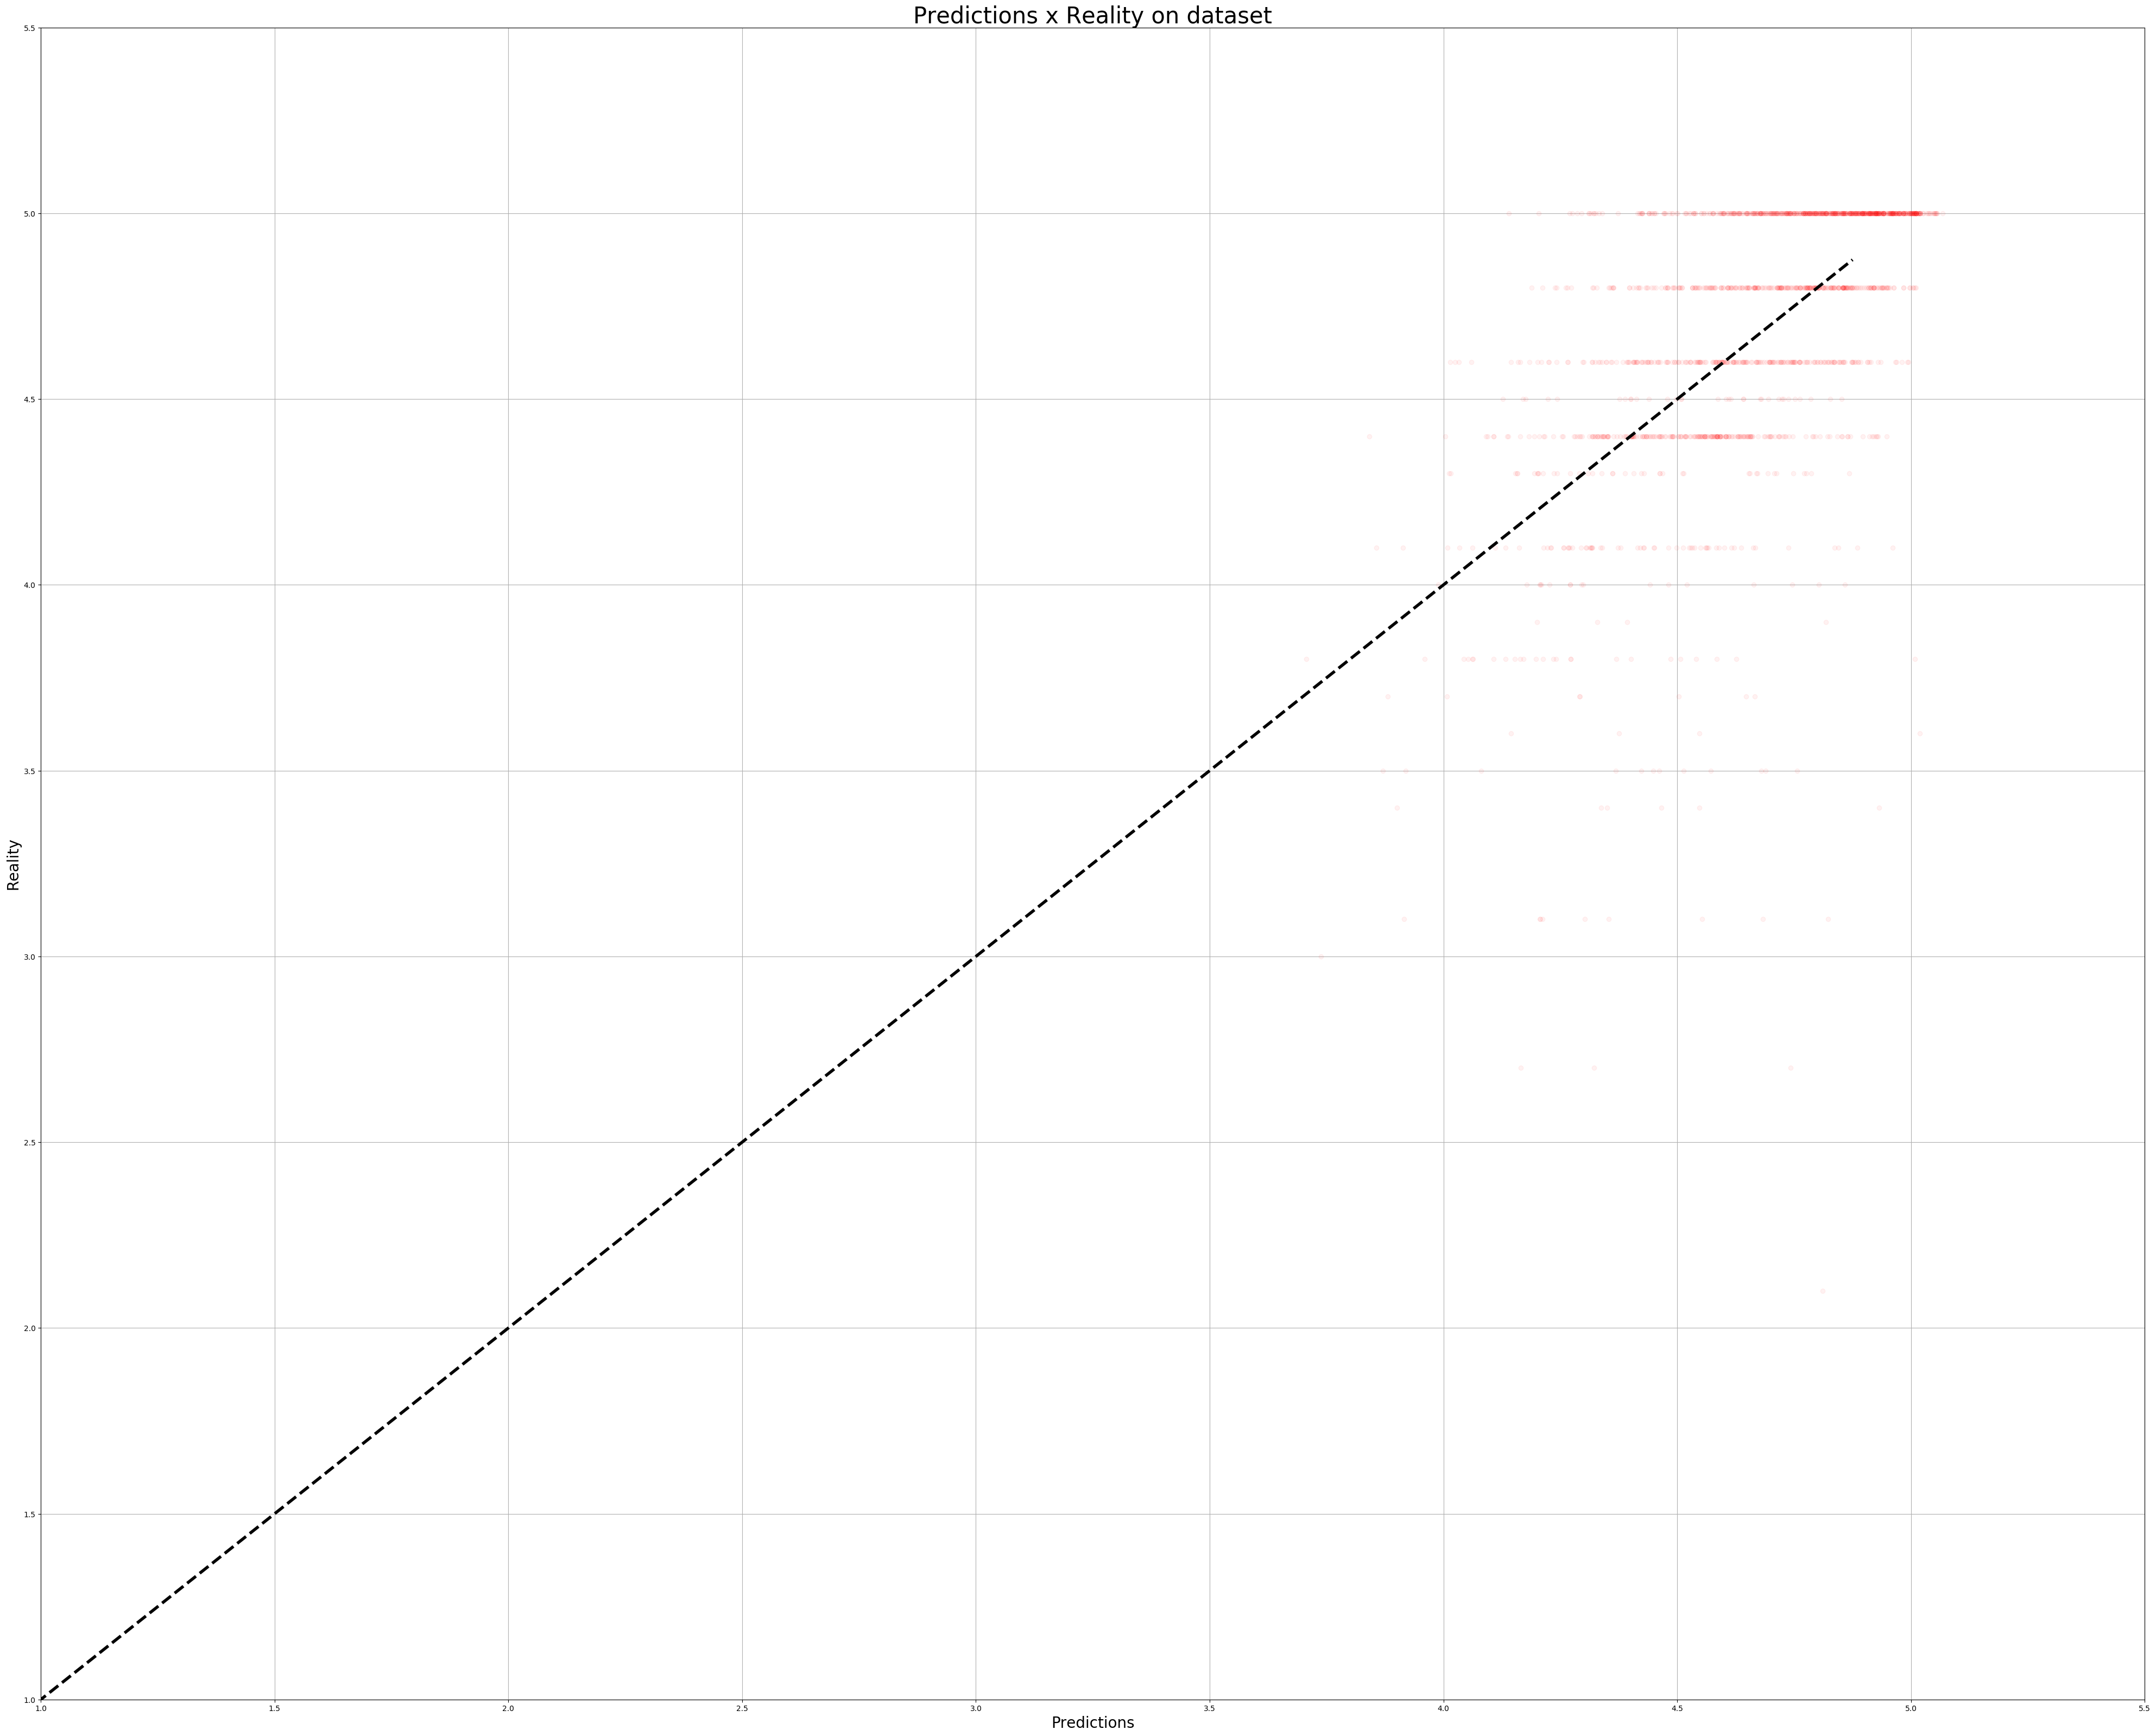

In [14]:
y = regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(train.drop([OUTPUT],axis = 1), shuffle=False))
predictions = list(itertools.islice(y, train.shape[0]))

# Plot predictions x reality on dataset graph


predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in predictions]).reshape(-1, 1))
reality = pd.DataFrame(prepro.inverse_transform(train), columns=[COLUMNS])[OUTPUT].values
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([1, 5.5])
axes.set_ylim([1, 5.5])
plt.style.use('default')
plt.plot(predictions, reality, 'ro', color='red',alpha = 0.05)
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Reality', fontsize=20)
plt.title('Predictions x Reality on dataset', fontsize=30)
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

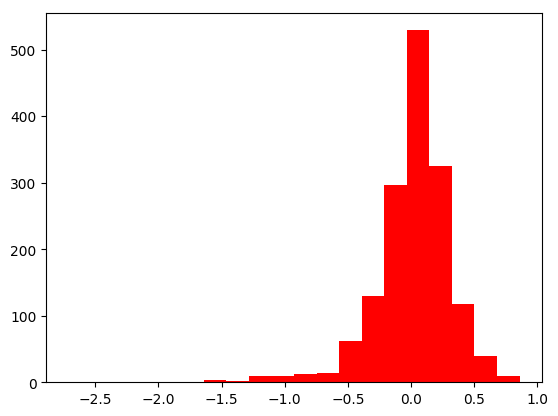

In [15]:
error = []
for x in (reality) - predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20,color='red') # plotting by columns
plt.show()

INFO:tensorflow:Calling model_fn.


Exception ignored in: <generator object Estimator.predict at 0x00000159038FDCA8>
Traceback (most recent call last):
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 5086, in get_controller
    yield g
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LucaC\AppData\Local\Temp\tmpjsveoeex\model.ckpt-11
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


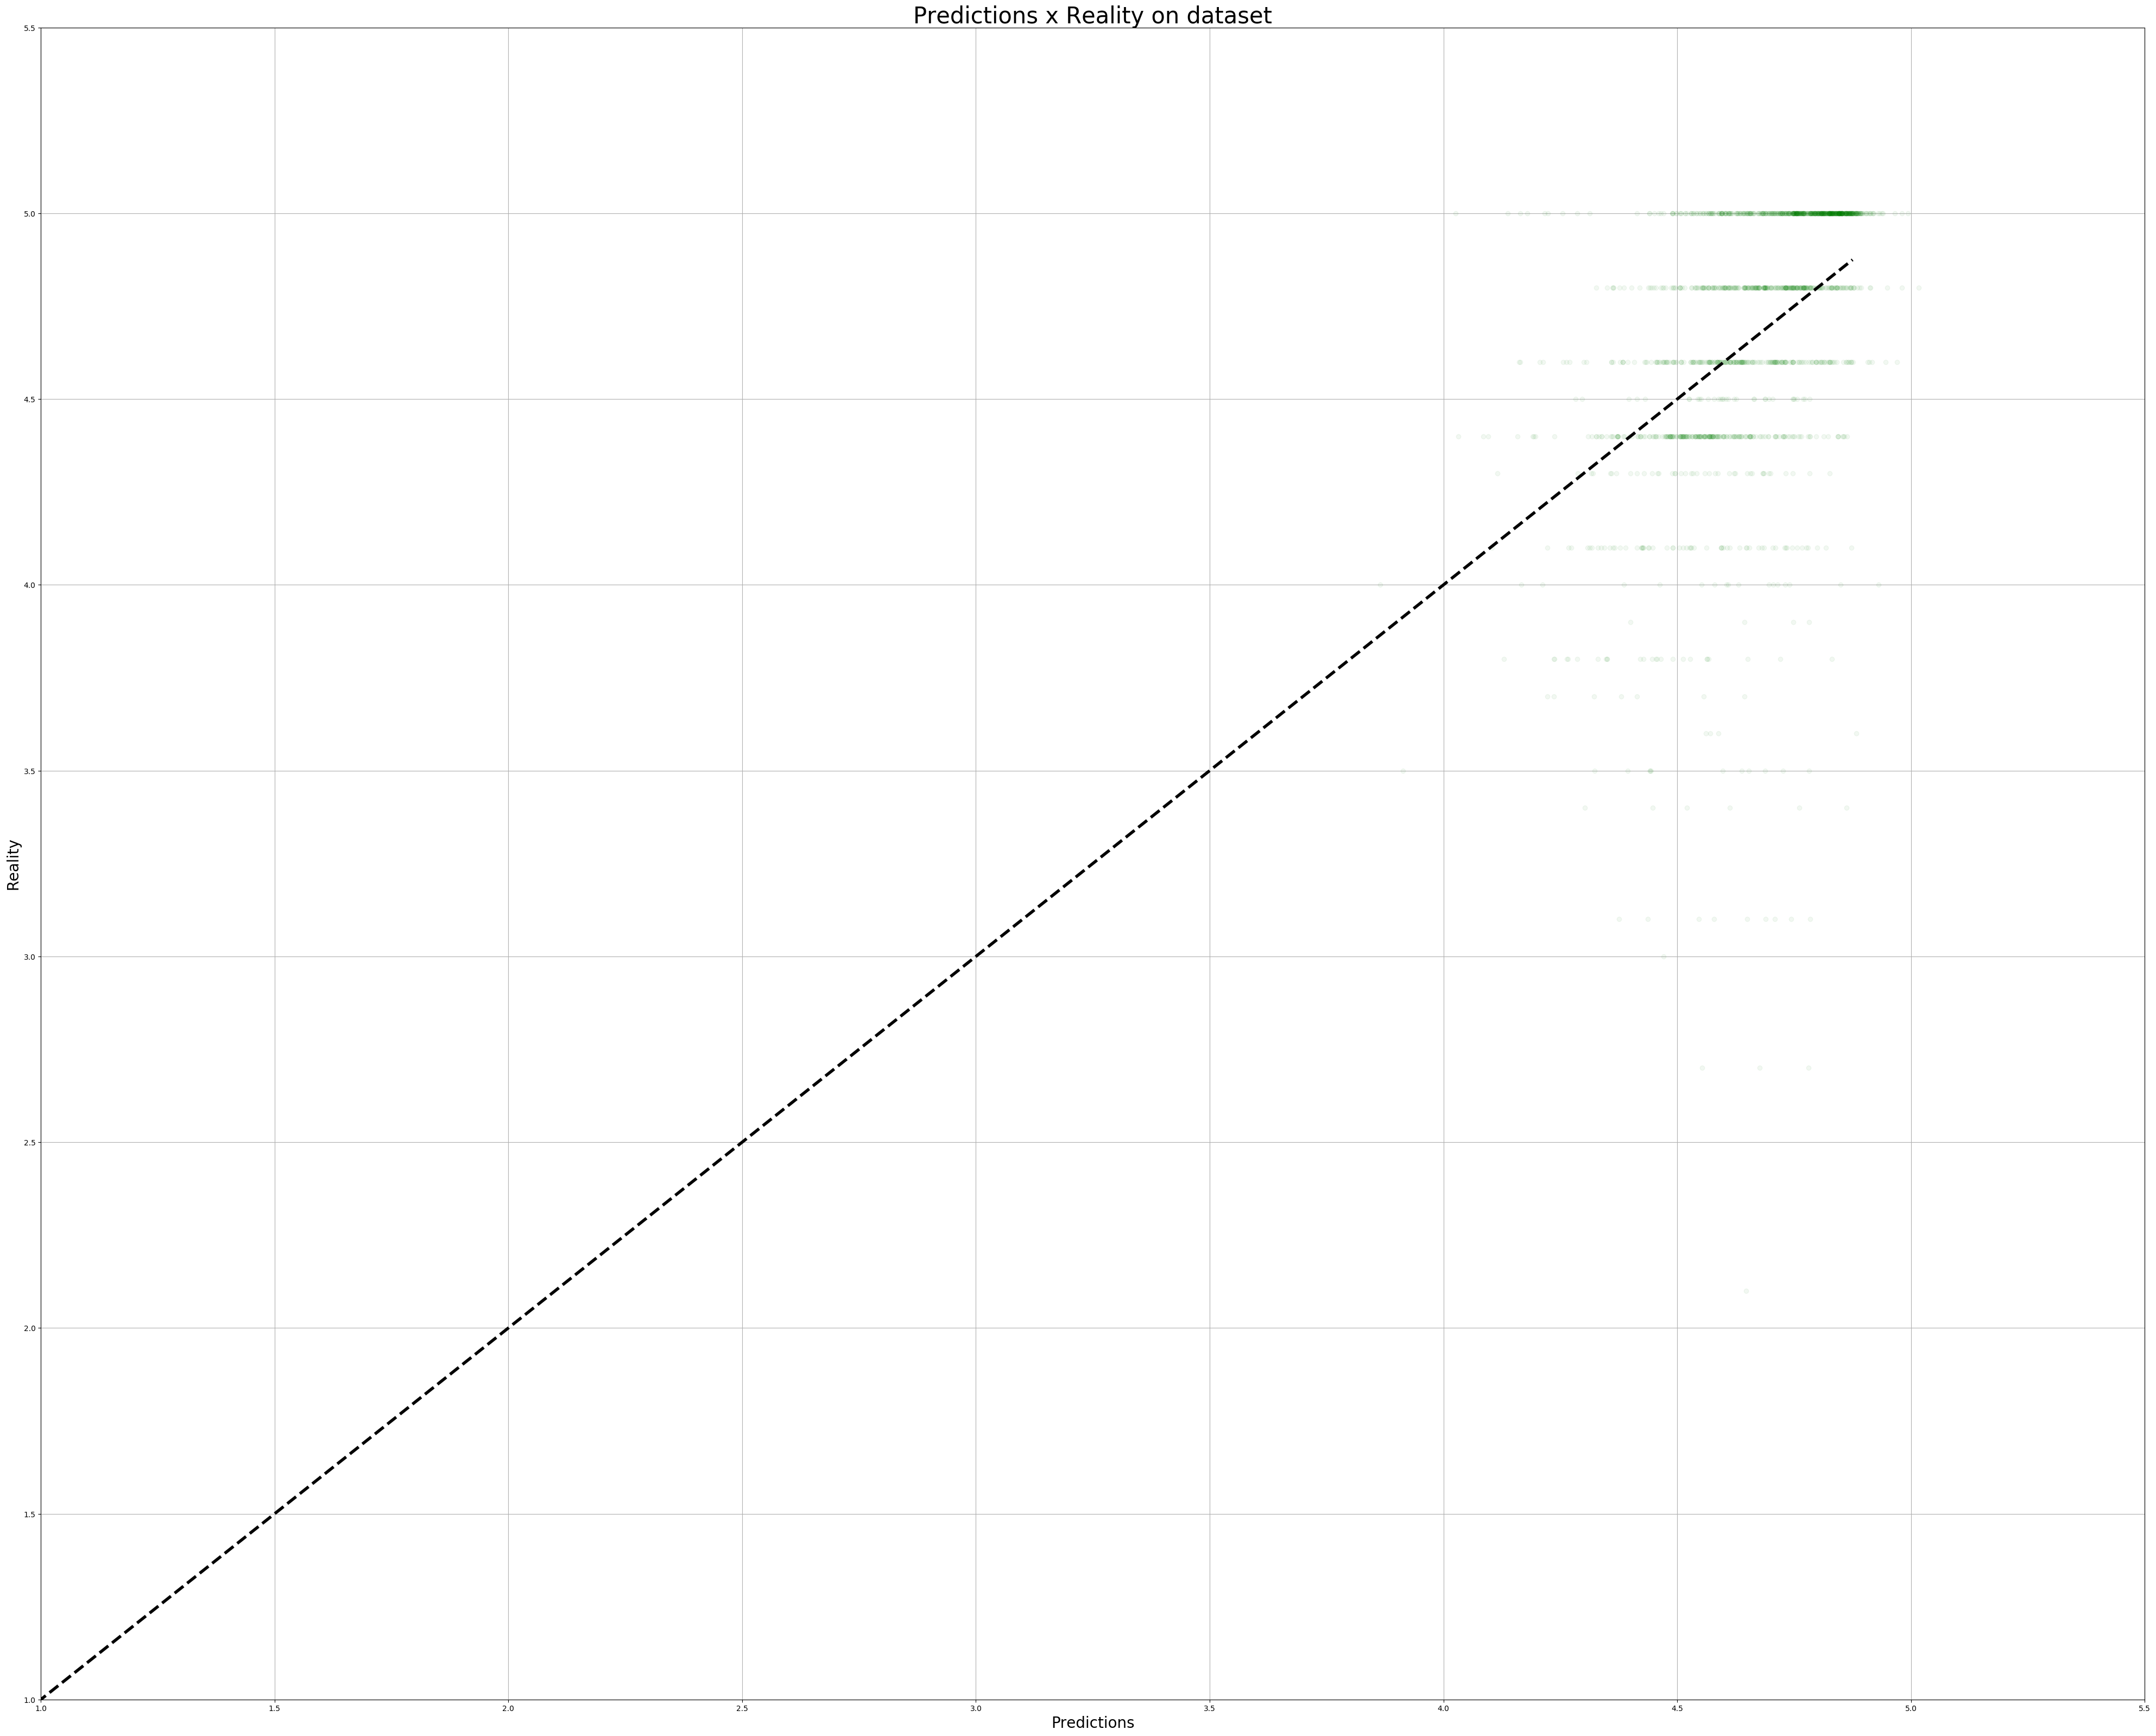

In [16]:
linear_y = linear_regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(train.drop([OUTPUT],axis = 1), shuffle=False))
linear_predictions = list(itertools.islice(linear_y, train.shape[0]))

# Plot predictions x reality on dataset graph


linear_predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in linear_predictions]).reshape(-1, 1))
linear_reality = pd.DataFrame(prepro.inverse_transform(train), columns=[COLUMNS])[OUTPUT].values
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([1, 5.5])
axes.set_ylim([1, 5.5])
plt.style.use('default')
plt.plot(linear_predictions, linear_reality, 'ro', color='green',alpha = 0.05)
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Reality', fontsize=20)
plt.title('Predictions x Reality on dataset', fontsize=30)
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

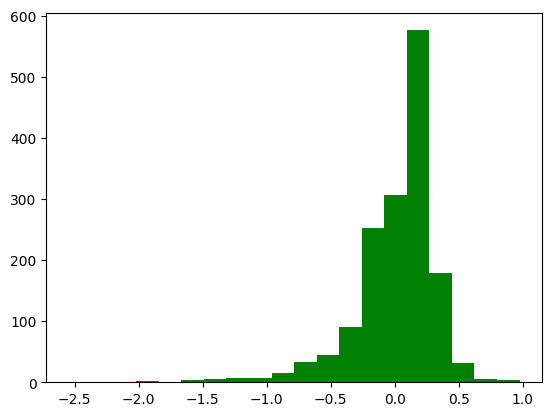

In [17]:
error = []
for x in linear_reality - linear_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20,color='green') # plotting by columns
plt.show()

c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


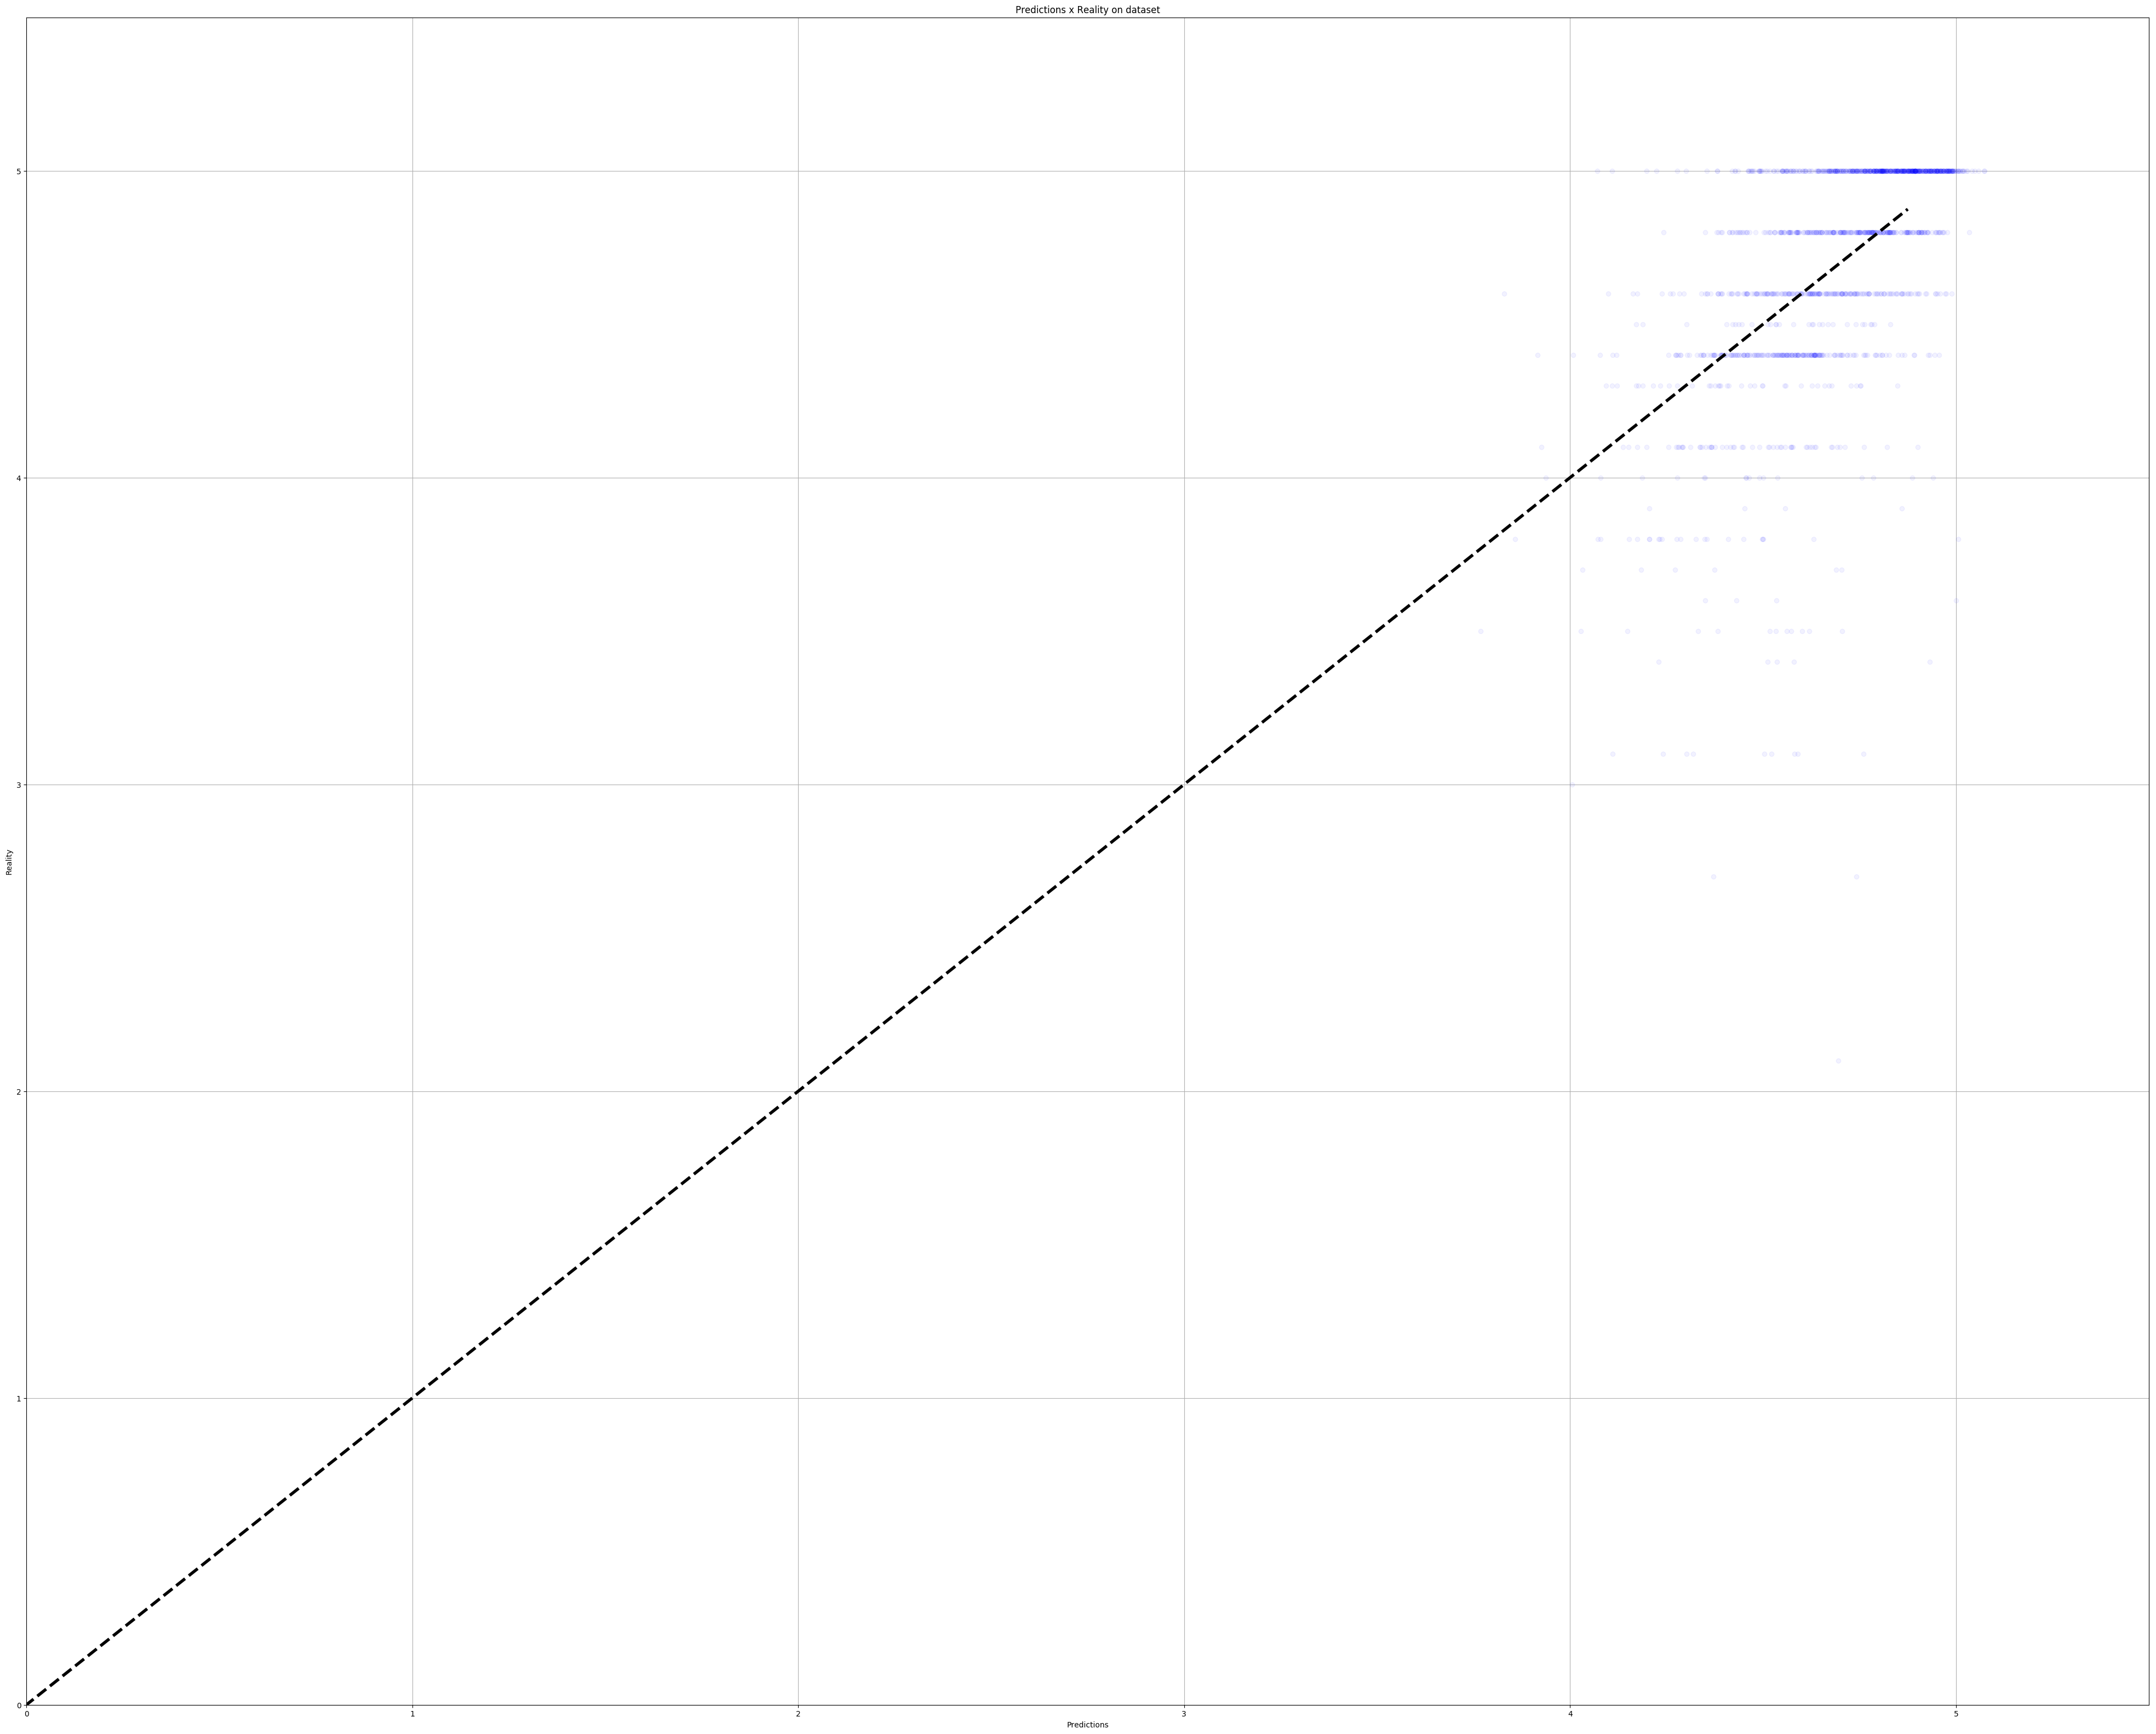

In [18]:
lr_sklearn_y = lr_sklearn.predict(np.matrix(training_set.drop([OUTPUT], axis=1)))

lr_sklearn_predictions = prepro_y.inverse_transform(lr_sklearn_y)
lr_sklearn_reality = pd.DataFrame(prepro.inverse_transform(training_set), columns=[COLUMNS])[OUTPUT].values

# Plot predictions x reality on dataset graph
    
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([0, 5.5])
axes.set_ylim([0, 5.5])
plt.style.use('default')
plt.plot(lr_sklearn_predictions, lr_sklearn_reality, 'ro', color='blue',alpha = 0.05)
plt.xlabel('Predictions')
plt.ylabel('Reality')
plt.title('Predictions x Reality on dataset')
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

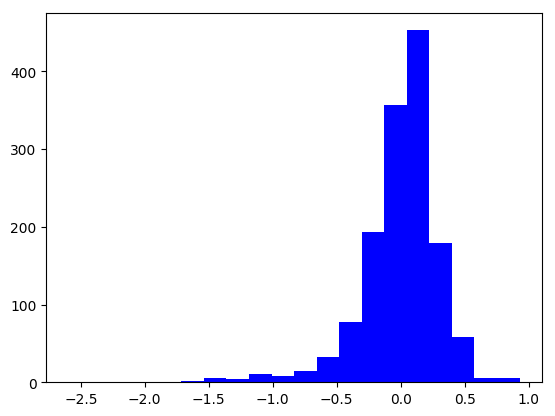

In [19]:
error = []
for x in (lr_sklearn_reality) - lr_sklearn_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20, color='blue') # plotting by columns
plt.show()

In [20]:
lista_colonne_json = list(train.columns.values)
scale_df = pd.DataFrame(columns= lista_colonne_json)
scale_df.loc[1] = prepro.mean_
scale_df.loc[2] = prepro.var_

lista_colonne_json.remove(OUTPUT)

df_coeff = pd.DataFrame(lr_sklearn.coef_, columns = lista_colonne_json)

scale_df = scale_df.append(df_coeff)
scale_df.to_json('Standardizzazione.txt',orient='records')
scale_df

,Go_score,Go_score+1,Go_score-1,Go_score-2,kinematicWorkload,mechanicalWorkload,metabolicWorkload,perceivedWorkload,rpe-1,rpe-2,workload,workload-1,workload-2
1,4.666773,4.678339,4.552716,4.577572,31.293099,36.763067,35.339744,36.052843,2.457827,2.551118,1.924473,1.442236,1.510671
2,0.105017,0.142528,0.195234,0.189075,768.642304,473.024144,772.875801,554.596767,3.944228,5.850422,1.243216,1.447794,1.908506
0,0.362047,NaN,0.042984,0.109281,-0.040815,-0.013297,0.121695,-0.213749,0.021885,-0.030063,-0.213419,0.018894,0.001391


In [31]:
df_total_temp = df_total.drop(['cardioWorkload','date','intensity','rpe','metabolicWorkload','workload',
                               'Player_Load','kinematicWorkload','mechanicalWorkload','perceivedWorkload','Go_score+1'
                              ], 
                              axis = 1)

player_list = df_total_temp['playerName'].unique()

new_df = pd.DataFrame()
for player in player_list:
    new_df = new_df.append(df_total_temp[df_total_temp['playerName'].isin([player])].sample(n=1))
    
new_df = new_df.reset_index(drop=True)
new_df.to_json('Giocatori.txt',orient='records')
new_df

,Go_score,playerName,workload-1,workload-2,rpe-1,rpe-2,Go_score-1,Go_score-2
0,4.4,Player1,1.8,0.7,3.0,2.0,4.4,3.8
1,4.0,Player10,2.3,1.9,5.0,3.0,4.6,4.5
2,4.3,Player11,1.4,1.7,3.0,3.0,4.3,4.3
3,4.8,Player12,1.3,2.3,1.0,4.0,4.3,5.0
4,5.0,Player13,1.5,2.1,2.0,3.0,5.0,5.0
5,4.5,Player14,1.8,1.1,4.0,3.0,5.0,4.0
6,4.3,Player15,0.0,0.6,0.0,2.0,3.7,4.4
7,4.3,Player16,5.1,2.2,10.0,4.0,4.5,4.3
8,4.5,Player17,2.0,0.7,5.0,0.0,4.5,4.5
9,4.4,Player18,0.0,0.0,0.0,0.0,4.4,4.1


In [21]:
linear_regressor.get_variable_names()

['global_step',
 'linear/linear_model/Go_score-1/weights',
 'linear/linear_model/Go_score-1/weights/part_0/Ftrl',
 'linear/linear_model/Go_score-1/weights/part_0/Ftrl_1',
 'linear/linear_model/Go_score-2/weights',
 'linear/linear_model/Go_score-2/weights/part_0/Ftrl',
 'linear/linear_model/Go_score-2/weights/part_0/Ftrl_1',
 'linear/linear_model/Go_score/weights',
 'linear/linear_model/Go_score/weights/part_0/Ftrl',
 'linear/linear_model/Go_score/weights/part_0/Ftrl_1',
 'linear/linear_model/bias_weights',
 'linear/linear_model/bias_weights/part_0/Ftrl',
 'linear/linear_model/bias_weights/part_0/Ftrl_1',
 'linear/linear_model/kinematicWorkload/weights',
 'linear/linear_model/kinematicWorkload/weights/part_0/Ftrl',
 'linear/linear_model/kinematicWorkload/weights/part_0/Ftrl_1',
 'linear/linear_model/mechanicalWorkload/weights',
 'linear/linear_model/mechanicalWorkload/weights/part_0/Ftrl',
 'linear/linear_model/mechanicalWorkload/weights/part_0/Ftrl_1',
 'linear/linear_model/metabolicWo

In [22]:
for x in linear_regressor.get_variable_names():
    print(x)
    print(linear_regressor.get_variable_value(x))
    print('\n')

global_step
11


linear/linear_model/Go_score-1/weights
[[0.02149251]]


linear/linear_model/Go_score-1/weights/part_0/Ftrl
[[23540.586]]


linear/linear_model/Go_score-1/weights/part_0/Ftrl_1
[[-16.487915]]


linear/linear_model/Go_score-2/weights
[[0.02689515]]


linear/linear_model/Go_score-2/weights/part_0/Ftrl
[[7143.531]]


linear/linear_model/Go_score-2/weights/part_0/Ftrl_1
[[-11.36581]]


linear/linear_model/Go_score/weights
[[0.3662535]]


linear/linear_model/Go_score/weights/part_0/Ftrl
[[22183.492]]


linear/linear_model/Go_score/weights/part_0/Ftrl_1
[[-272.75125]]


linear/linear_model/bias_weights
[-0.03304303]


linear/linear_model/bias_weights/part_0/Ftrl
[5234.4194]


linear/linear_model/bias_weights/part_0/Ftrl_1
[11.953199]


linear/linear_model/kinematicWorkload/weights
[[0.01306905]]


linear/linear_model/kinematicWorkload/weights/part_0/Ftrl
[[30758.873]]


linear/linear_model/kinematicWorkload/weights/part_0/Ftrl_1
[[-11.460384]]


linear/linear_model/mechanical